# Threat Search Policy
The ```ThreatSearchPolicy``` suggests all moves that can be used in threat sequences or defense against those. A *threat* is a move that mandates immediate defensive action for the opponent, i.e. any failure to defend appropriately will inevitably lead to defeat for the opponent further along the threat sequence.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from domoku import tools as gt
from alphazero.gomoku_board import GomokuBoard

In [3]:
BOARD_SIZE = 15

In [4]:
stones = "C11F9E9G8F7G7G9H8I8H7I6I9F6H6H9I5J4"

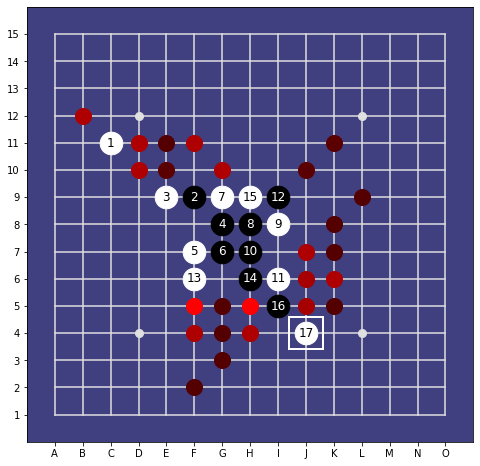

In [23]:
from domoku.board import GomokuBoard as LegacyBoard

heuristics = lambda s: policy(s)[0]
_stones = gt.string_to_stones(stones)
board_t = LegacyBoard(n=BOARD_SIZE, disp_width=8, stones=_stones, heuristics=heuristics)
board_t.display()

---
# The new threat model components


## Primary Detector Layer

The primary detector takes the stones and boundary as input and outputs 5 channels. The first three are just projections of the input, the 4th channel identifies critical positions of the current player, and the fifth channel those of the other player.

In [5]:
board = GomokuBoard(BOARD_SIZE, stones)
Move = board.Stone

In [6]:
from domoku.policies.primary_detector import PrimaryDetector

detector = PrimaryDetector(BOARD_SIZE)

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [7]:
output = np.squeeze(detector(board.math_rep))
output.shape

2022-07-10 15:16:15.736027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(17, 17, 5)

### The projected board

In [8]:
gt.print_channels(output)

shape: (17, 17, 5)
[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 2. 1. 2. 2. 1. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 1. 1. 2. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 2. 0. 1. 2. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]


### Threat critical open positions of current and other player

In [9]:
print(output[:, :, 3])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [10]:
print(output[:, :, 4])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Forward-Looking Layers
Forward-looking layers treat threat positions as potential stones

In [14]:
from domoku.policies.forward_looking import ForwardLookingLayer

fwll = ForwardLookingLayer(BOARD_SIZE)

In [15]:
output = detector(board.math_rep)
fwd = np.squeeze(fwll(fwll(output)))

In [16]:
print((fwd[:, :, 3]*100.).astype(int))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0   0   0 100   0   0   0   0   0]
 [  0   0   0   0   0 100   0   0  91   0 100   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  91   0  91   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  91   0 284   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 284   0  91   0   0   0   0]
 [  0   0   0   0   0   0 284 284 384   0 284 284  91   0   0   0   0]
 [  0   0   0   0   0   0  91   0 384   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  91   0 284   0   0   0   0   0   0   0   0   0]
 [  0 

In [17]:
print((fwd[:, :, 4]*100.).astype(int))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 292   0   0  91   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  91   0 284 284 384   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 292  91   0 292   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 284   0   0   0   0]
 [  0   0   0   0   0  91   0   0   0   0   0 284   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 384   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  91   0   0 284 292   0   0   0   0   0]
 [  0   0   0   0   0   0 292   0 284   0 284   0   0   0   0   0   0]
 [  0   0   0   0   0   0 292 284  91  91   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  91   0   0   0  91   0   0   0   0   0   0]
 [  0 

---

# The combined heuristic policy-value function

### TODO: Take this policy into the Arena.ipynb to continue MCTS research!

In [21]:
from domoku.policies.heuristic_policy import HeuristicPolicy

# cut_off is used to restrict advice to those positions close enough to the maximum
policy = HeuristicPolicy(BOARD_SIZE, cut_off=.1)

In [22]:
pi = lambda s: policy(s)[0]
v =  lambda s: policy(s)[1]
board.print_pi(pi)
print()
print(v(board.math_rep))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 674   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 674 324 674   0   0   0   0 349   0   0   0   0]
 [  0   0   0 674 349   0 674   0   0 349   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 324   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 324   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 674 324   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 649 674   0   0   0   0]
 [  0   0   0   0   0 999 324 999   0 649 324   0   0   0   0]
 [  0   0   0   0   0 674 324 674   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 324   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 324   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

tf.Tensor(-0.012613215651775575, shape=(), dtype=floa

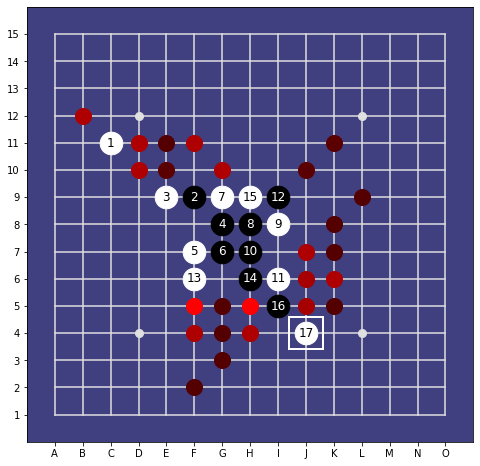

In [23]:
from domoku.board import GomokuBoard as LegacyBoard

heuristics = lambda s: policy(s)[0]
_stones = gt.string_to_stones(stones)
board_t = LegacyBoard(n=BOARD_SIZE, disp_width=8, stones=_stones, heuristics=heuristics)
board_t.display()

Observe that all critical positions are also *advisable*.

In [24]:
print([Move(a) for a in policy.get_advisable_actions(board.math_rep)])

[B12, D11, E11, F11, K11, D10, E10, G10, J10, L9, K8, J7, K7, J6, K6, F5, G5, H5, J5, K5, F4, G4, H4, G3, F2]


## Super-critical positions

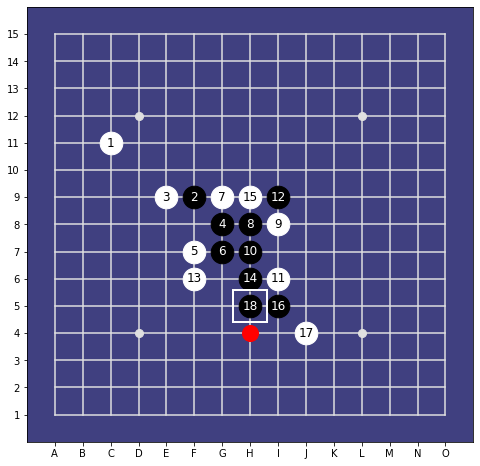

In [25]:
board_t.set('H', 5)
board_t.display()

In [26]:
board.act('H5')

C11 F9 E9 G8 F7 G7 G9 H8 I8 H7 I6 I9 F6 H6 H9 I5 J4 H5

In [28]:
board.print_pi(pi)
print()
print(v(board.math_rep))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   5   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   5   2   5   0   0   0   0   2   0   0   0   0]
 [  0   0   0   5   2   0   5   0   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2   5   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   5   5   0   0   0   0]
 [  0   0   0   0   0  11   5   0   0   8   5   0   0   0   0]
 [  0   0   0   0   0   8   0 999   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

tf.Tensor(-0.5056339695553365, shape=(), dtype=float6

Compare that to the raw logits, where we expect a $333$ for a 'Must-defend'

In [29]:
c, o = policy.logits(board.math_rep)
print((c+o).astype(int))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   1   0   0   0   0   1   0   0   0   0]
 [  0   0   0   1   1   0   1   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   1   0   0   0   0]
 [  0   0   0   0   0   3   1   0   0   2   1   0   0   0   0]
 [  0   0   0   0   0   2   0 333   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


Please observe that the advisable actions don't include non-zero positions that are too irrelevant as compared to the critical maximum. This is the behaviour that we want: Explore only where it makes sense.

With the super-criticality, the (still) critical positions are no longer advisable.

In [30]:
[Move(action) for action in policy.get_advisable_actions(board.math_rep)]

[H4]

## Values from the current player's point of view

In [31]:
board.act('J5')

C11 F9 E9 G8 F7 G7 G9 H8 I8 H7 I6 I9 F6 H6 H9 I5 J4 H5 J5

In [33]:
board.print_pi(pi)
print()
print(v(board.math_rep))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   1   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0 999   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

tf.Tensor(0.926511707164987, shape=(), dtype=float64)

Please observe that the sign of the value function changes. We're always computing the value from the point of view of the current player.